In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['C.test_data201803.csv']


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import torch
from torch import nn
from torch.autograd import Variable as V
from torch import optim
import torchvision as tv
import torchvision.transforms as tf

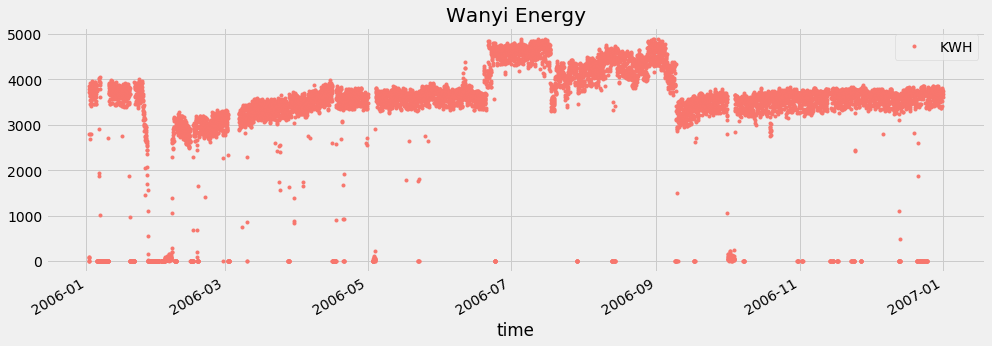

In [3]:
#pjme = pd.read_csv('../input/wanyi-energy/C.test_data201803.csv', index_col=[1], usecols=[2])
df_wanyi = pd.read_csv('../input/C.test_data201803.csv', index_col=[1], parse_dates=[1])

df_wanyi = df_wanyi.drop(columns="Unnamed: 0")
df_wanyi.index = df_wanyi.index+pd.Timedelta(minutes=1)

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df_wanyi.plot(style='.', figsize=(15,5), color=color_pal[0], title='Wanyi Energy')

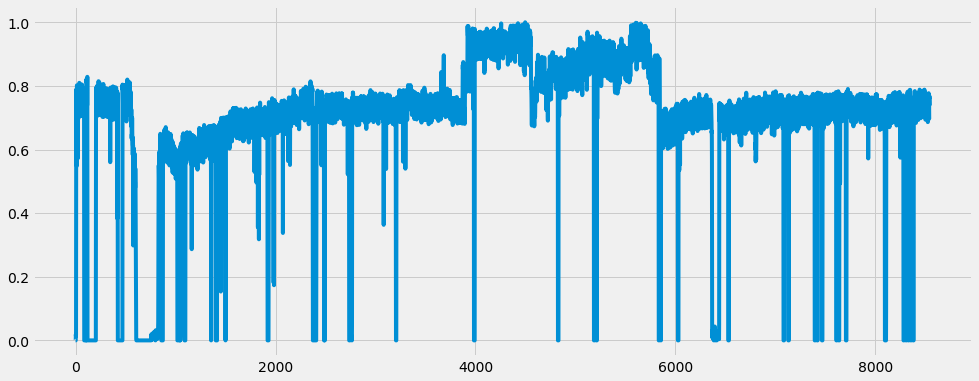

In [4]:
plt.figure(figsize=(15,6))
data_csv = df_wanyi.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))
plt.plot(dataset)

In [5]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [6]:
look_back = 5
data_X, data_Y = create_dataset(dataset, look_back)

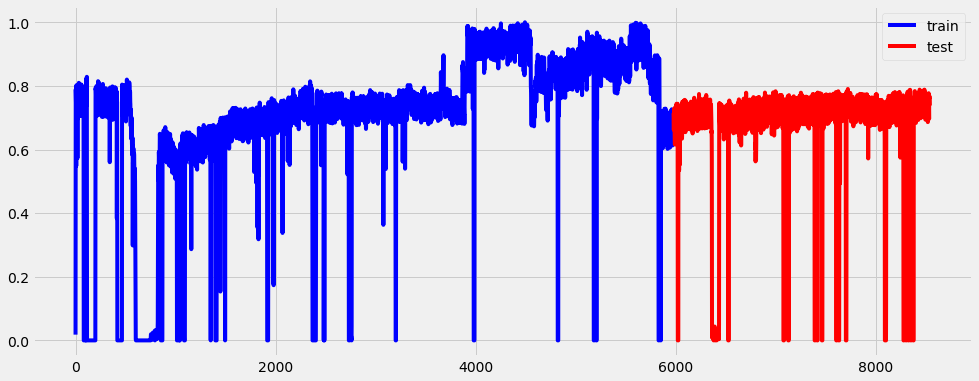

In [7]:
plt.figure(figsize=(15,6))
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]
x1=np.arange(0,train_size)
x2 = np.arange(train_size,train_size+len(test_Y))
plt.plot(x1,train_Y,'b',label='train')
plt.plot(x2, test_Y, 'r', label='test')
plt.legend(loc='best')

In [8]:

train_X = train_X.reshape(-1, 1, look_back)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, look_back)
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
train=torch.zeros(len(train_x),1,look_back+1)
train[:,:,:look_back]=train_x
train[:,:,look_back:(look_back+1)]=train_y
train = torch.utils.data.DataLoader(
    train,
    batch_size=12719,
    shuffle=False,
    num_workers=2
    )


In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1,num_layers=2):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(  
            input_size,
            hidden_size,  
             num_layers,  
        )
        self.reg = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        x,_=self.rnn(input)
        s,b,h=x.shape
        x=x.view(s*b,h)
        x=self.reg(x)
        x=x.view(s,b,-1)
        return x

In [10]:
rnn = RNN(look_back,4)
print(rnn)
optimizer=torch.optim.Adam(rnn.parameters(),lr=0.01)
criterion=nn.MSELoss()

RNN(
  (rnn): LSTM(5, 4, num_layers=2)
  (reg): Linear(in_features=4, out_features=1, bias=True)
)


In [11]:
for e in range(20):
    for i, data in enumerate(train, 0):
        var_x = V(data[:,:,:look_back])
        var_y = V(data[:,:,look_back:(look_back+1)])
        out = rnn(var_x)
        loss = criterion(out, var_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (e + 1) % 1 == 0: 
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 1, Loss: 0.52760
Epoch: 2, Loss: 0.47527
Epoch: 3, Loss: 0.42868
Epoch: 4, Loss: 0.38647
Epoch: 5, Loss: 0.34745
Epoch: 6, Loss: 0.31072
Epoch: 7, Loss: 0.27577
Epoch: 8, Loss: 0.24244
Epoch: 9, Loss: 0.21080
Epoch: 10, Loss: 0.18118
Epoch: 11, Loss: 0.15412
Epoch: 12, Loss: 0.13022
Epoch: 13, Loss: 0.10990
Epoch: 14, Loss: 0.09323
Epoch: 15, Loss: 0.07990
Epoch: 16, Loss: 0.06944
Epoch: 17, Loss: 0.06136
Epoch: 18, Loss: 0.05523
Epoch: 19, Loss: 0.05071
Epoch: 20, Loss: 0.04753


In [12]:
rnn = rnn.eval()

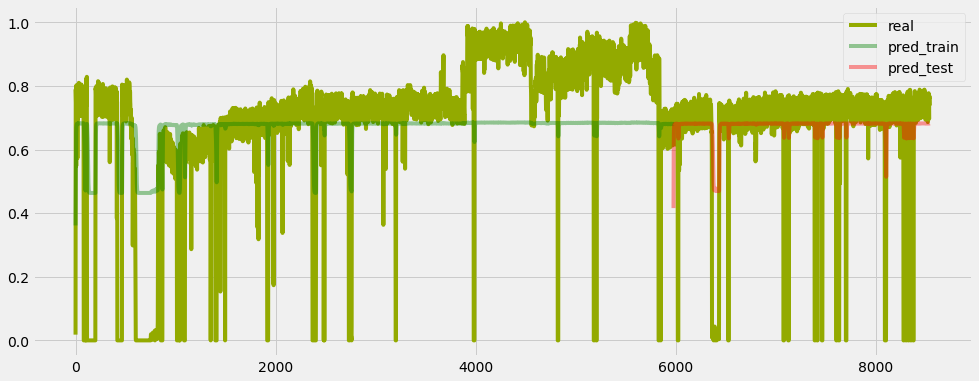

In [13]:
train_x = V(train_x)
outputs_train = rnn(train_x)
pred_train = outputs_train.view(-1).data.numpy()
inputs=V(test_x)
outputs=rnn(inputs)
predicted = outputs.view(-1).data.numpy()
plt.figure(figsize=(15,6))
plt.plot(data_Y, 'k', label='real', color='#93AA00')
plt.plot(pred_train, 'g' , label='pred_train',alpha=0.4)
plt.plot(x2,predicted,'r',label='pred_test',alpha=0.4)
plt.legend(loc='best')

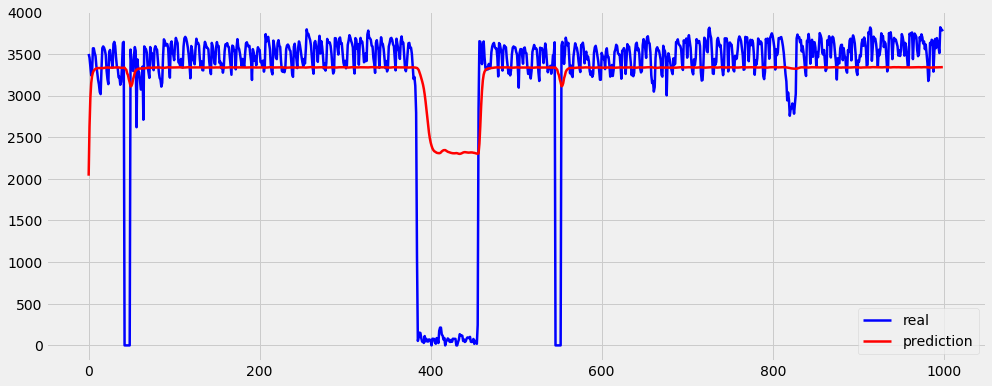

In [14]:
plt.figure(figsize=(15,6))
test_Y = list(map(lambda x: x*scalar+min_value , test_Y))
predicted = list(map(lambda x: x*scalar+min_value, predicted))
plt.plot(test_Y[0:1000], 'b', linewidth=2.5, linestyle="-",label='real')
plt.plot(predicted[0:1000], 'r',linewidth=2.5, linestyle="-", label='prediction')
plt.legend(loc='best')

In [15]:
def mean_absolute_percentage_error(y_true, y_pred):
    error=np.array(np.abs((y_true - y_pred) / y_pred))
    return np.mean(error,axis=0) * 100

In [16]:
test_Y = np.array(test_Y).reshape(-1,1)
predicted = np.array(predicted).reshape(-1,1)
error=mean_absolute_percentage_error(y_true=test_Y,y_pred=predicted)
print('MAPE:%0.5f%%'%error)

MAPE:14.53829%
